In [685]:
# Packages
using Flux, CairoMakie

In [686]:
# Test data
f = x-> cos(x)+sin(x)
x_train_range = range(0,stop=2pi,step=(1/8*pi))
x_test_range = range(0,stop=2pi,step=(pi/4))

x_train = hcat(x_train_range...)
x_test = hcat(x_test_range...)

y_train = map(f,x_train)
y_test = map(f,x_test)

InputDim = size(x_train)[1]
Nh = 80
OutputDim = size(x_train)[1]
Layers = 1
activation = sigmoid

display(y_train)

1×17 Matrix{Float64}:
 1.0  1.30656  1.41421  1.30656  1.0  …  -3.33067e-16  0.541196  1.0

In [693]:
model = Chain(Dense(1,Nh,sigmoid),Dense(Nh,1))|>f64

Chain(
  Dense(1 => 80, σ),                    # 160 parameters
  Dense(80 => 1),                       # 81 parameters
)                   # Total: 4 arrays, 241 parameters, 2.133 KiB.

In [694]:
# Prediction and loss
y_train_hat =  model(x_train)
y_test_hat = model(x_test)

Loss(model,x,y) = Flux.mse(y,model(x));
loss = Loss(model,x_train,y_train)

2.0489157958564648

In [695]:
include("NTKernel.jl")

kernel (generic function with 1 method)

In [696]:
K = kernel(model,x_train)/sqrt(Nh)
λ = eigen(K).values
λ .= abs.(λ)
λ .= sort!(λ)

17-element Vector{Float64}:
  1.0965704164495296e-17
  1.214092679603676e-16
  1.7272155818022745e-16
  1.9116425619088262e-16
  2.087858827053353e-16
  2.2949957363620322e-16
  3.0838483189999783e-16
  3.543605207979817e-16
  5.275875648435945e-16
  4.320946081253363e-14
  3.651372426416961e-12
  7.532327714078049e-10
  3.5181600921236393e-7
  8.82899671883009e-6
  0.005119333616212141
  1.1801322654775626
 45.24584280753735

In [697]:
# Training
train_data = [(x_train,y_train)]
opt = Descent(1/λ[end])


Nepoch = 50000
Process_Loc = [1000]
Process = []
for epoch=1:Nepoch
    Flux.train!(Loss, model, train_data, opt)
    if epoch in Process_Loc
        push!(Process,model(x_train))
    end
end

Process = hcat(Process)

y_train_hat =  model(x_train)



1×17 Matrix{Float64}:
 1.00629  1.2976  1.40424  1.30889  1.01486  …  -0.0542931  0.493784  1.06219

In [698]:
# loss update 
loss_updt = round(Loss(model,x_train,y_train),digits=5)

0.0008

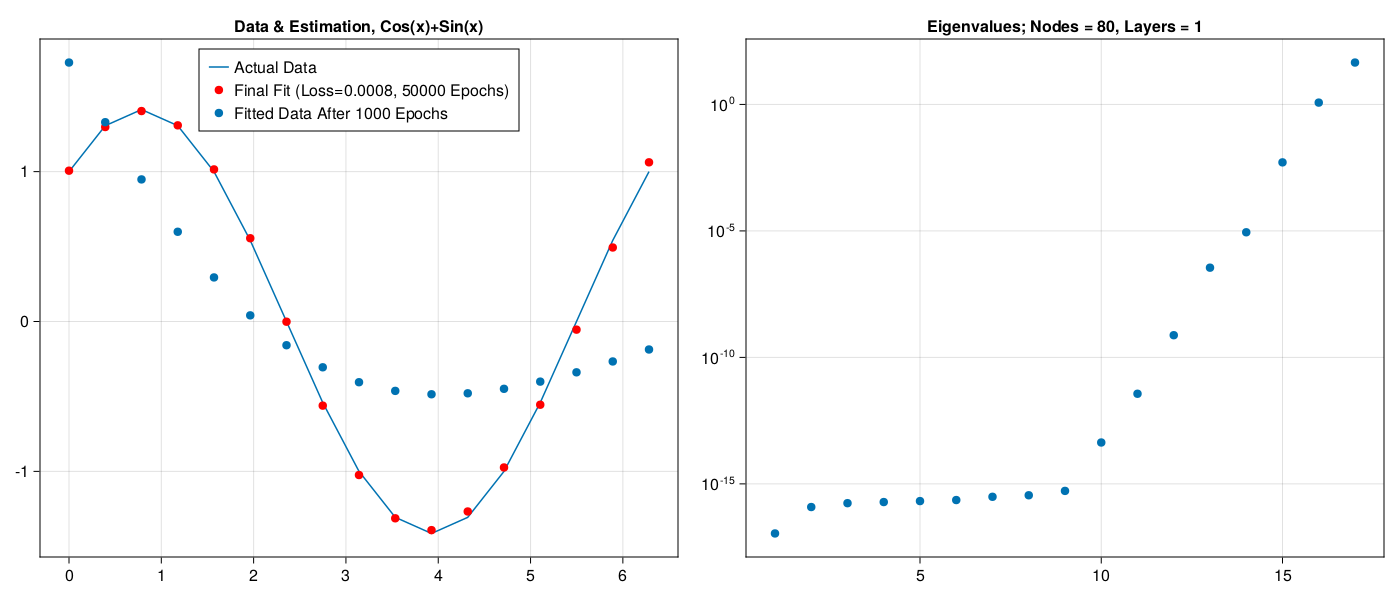

In [699]:
# Plotting

fig = Figure(resolution = (1400, 600))
ax1 = Axis(fig[1,1],title="Data & Estimation, Cos(x)+Sin(x)")
ax2 = Axis(fig[1,2],title="Eigenvalues; Nodes = $Nh, Layers = $Layers",yscale=log10)
s1 = lines!(ax1,x_train[:],y_train[:],label="Actual Data")
s2 = scatter!(ax1,x_train[:],y_train_hat[:],label="Final Fit (Loss=$loss_updt, $Nepoch Epochs)",color=:red)

for P in 1:length(Process)
    P_num = Process_Loc[P]
    scatter!(ax1,x_train[:],Process[P][:],label="Fitted Data After $P_num Epochs")
end

scatter!(ax2,1:length(λ),λ[:])
# Create a legend for ax1 with the specified scatter plots
axislegend(ax1,position=:ct)
fig